# medMNIST exploration

In [1]:
# for dterministic=True
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import medmnist
print(medmnist.__version__)

3.0.2


In [3]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")


Torch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124


In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [5]:
# read in the PneumoniaMNIST dataset
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=224)
test_dataset = PneumoniaMNIST(split='test', download=True, size=224)
val_dataset = PneumoniaMNIST(split='val', download=True, size=224)
# print the dataset info
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 4708
Number of test samples: 624
Number of validation samples: 524


### Make a custom sized training dataset

In [6]:
from torch.utils.data import Subset

# Number of positive samples needed
pos_samples = 5

# Get the labels from the dataset (0 for normal, 1 for pneumonia)
labels = train_dataset.labels.flatten()

# Find the indices for the positive (pneumonia) and negative (normal) classes
positive_indices = np.where(labels == 1)[0]
negative_indices = np.where(labels == 0)[0]
num_orig_positive = len(positive_indices)
num_orig_negative = len(negative_indices)
print(f"Original positive samples (pneumonia): {num_orig_positive}")
print(f"Original negative samples (normal): {num_orig_negative}")

# --- Create the new dataset ---

# 1. Randomly sample "pos_samples" indices from the positive class
#    We use replace=False to ensure each selected index is unique.
#    A random seed is used for reproducibility.
np.random.seed(42)
sampled_positive_indices = np.random.choice(positive_indices, pos_samples, replace=False)

# 2. Combine the "pos_samples" positive indices with all negative indices
final_indices = np.concatenate([sampled_positive_indices, negative_indices])

# 3. Create the new subset dataset using the combined indices
new_train_dataset = Subset(train_dataset, final_indices)


# --- Verification (Optional) ---
# You can verify the composition of your new dataset

new_labels = labels[final_indices]
num_positive = np.sum(new_labels == 1)
num_negative = np.sum(new_labels == 0)

print(f"Original dataset size: {len(train_dataset)}")
print(f"New dataset size: {len(new_train_dataset)}")
print("-" * 30)
print(f"Samples in new dataset:")
print(f"  - Positive (pneumonia): {num_positive}")
print(f"  - Negative (normal):    {num_negative}")
print(f"  - Total:                {len(new_labels)}")

# You can now use 'new_train_dataset' in your DataLoader
# from torch.utils.data import DataLoader
# train_loader = DataLoader(dataset=new_train_dataset, batch_size=32, shuffle=True)



Original positive samples (pneumonia): 3494
Original negative samples (normal): 1214
Original dataset size: 4708
New dataset size: 1219
------------------------------
Samples in new dataset:
  - Positive (pneumonia): 5
  - Negative (normal):    1214
  - Total:                1219


In [7]:
print(type(train_dataset[0]))
print(len(train_dataset[0]))
image, label = train_dataset[0]
print(type(image))


<class 'tuple'>
2
<class 'PIL.Image.Image'>


In [8]:
from matplotlib import pyplot as plt

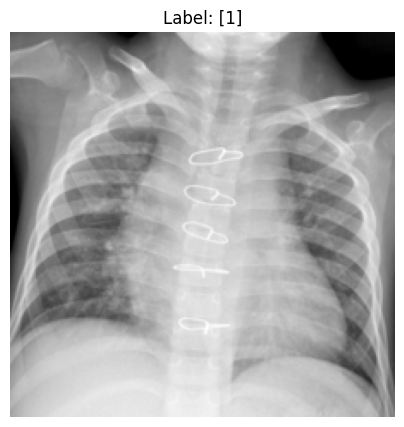

In [9]:
# print 1st 10 samples
for i in range(1):
    image, label = train_dataset[i]
    plt.figure(figsize=(5, 5))
    #image = image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C) for plotting
    plt.imshow(image, cmap='gray' if image.mode == 'L' else None)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Hide the axes
    plt.show()

In [10]:
# number of samples of each class
postive_count = sum(1 for _, label in train_dataset if label == 1)
negative_count = sum(1 for _, label in train_dataset if label == 0)
print(f"Number of positive samples: {postive_count}")
print(f"Number of negative samples: {negative_count}")

Number of positive samples: 3494
Number of negative samples: 1214


In [11]:
info =INFO['pneumoniamnist']
print(info)
n_channels = info['n_channels']
n_classes = info['label']
print("Number of channels:",n_channels)
print("Number of classes",n_classes)

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

In [12]:
dataiter = iter(train_dataset)
image, label = next(dataiter)
print(image.size)
print(label.shape)

(224, 224)
(1,)


### Hyperparameters
* BATCH_SIZE
* LEARNING_RATE
* NUM_EPOCHS
* IMAGE_SIZE
* NUM_CLASSES
* NUM_CHANNELS



In [13]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 10
NUM_WORKERS = 4

### Create the SequentialNN classifier class

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, image_height, image_width):
        super(SimpleCNN, self).__init__()
        #Convoluional layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 224x224 -> 112x112
        
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 112x112 -> 56x56
        
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 56x56 -> 28x28
        
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        )

        # --- DYNAMIC FLATTENED SIZE CALCULATION ---
        # Create a dummy tensor with the specified input dimensions
        dummy_input = torch.randn(1, in_channels, image_height, image_width)
        # Pass it through the feature extractor to see the output shape
        dummy_output = self.features(dummy_input)
        # The number of elements in the output tensor is our flattened size
        self.flattened_size = dummy_output.numel()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.relu_fc = nn.ReLU()
        # Output layer: num_classes=1 for binary classification (outputting logits)
        self.fc2 = nn.Linear(512, num_classes)

    def extract_features(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu_fc(x)
        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.fc2(x)
        return x


## Lightning Module

In [15]:
import torchmetrics
import pytorch_lightning as pl

class LitSimpleCNN(pl.LightningModule):
    def __init__(self, in_channels, num_classes, learning_rate, image_height, image_width, training_mode='full_network'):
        super().__init__()
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Define the model
        self.model = SimpleCNN(
            in_channels=self.hparams.in_channels, 
            num_classes=self.hparams.num_classes,
            image_height=self.hparams.image_height,
            image_width=self.hparams.image_width
        )
        
        # Define loss function
        self.criterion = nn.BCEWithLogitsLoss()

        # Define metrics
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")

        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        self.test_precision = torchmetrics.Precision(task="binary")
        self.test_recall = torchmetrics.Recall(task="binary")
        self.test_f1 = torchmetrics.F1Score(task="binary")

        # This list will store outputs from each test step
        self.last_test_results = {}
        self.test_step_outputs = []


    def forward(self, x):
        return self.model(x)
    
    def freeze_feature_extractor(self):
        print("Freezing feature extractor layers...")
        for param in self.model.features.parameters():
            param.requires_grad = False
        for param in self.model.fc1.parameters():
            param.requires_grad = False

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        # For BCEWithLogitsLoss, labels must be float
        labels = labels.float()
        
        outputs = self(inputs) # Forward pass
        loss = self.criterion(outputs, labels)

        # We need to handle which part of the network we are training
        if self.hparams.training_mode == 'full_network':
            self.log('train_loss_full', loss)
        elif self.hparams.training_mode == 'classifier_only':
            self.log('train_loss_classifier', loss)
        
        # Log metrics
        self.train_accuracy(outputs, labels.int())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('train_acc', self.train_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        labels = labels.float()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        # Log metrics
        self.val_accuracy(outputs, labels.int())
        self.val_auc(outputs, labels.int())
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        self.log('val_auc', self.val_auc, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels.float())
        
        # Append predictions and labels to our list
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        # Log the loss for this batch
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        # Concatenate all predictions and labels from the list we built
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # Calculate final metrics over the entire test set
        test_acc = self.test_accuracy(all_preds, all_labels.int())
        test_auc_val = self.test_auc(all_preds, all_labels.int())
        test_prec = self.test_precision(all_preds, all_labels.int())
        test_rec = self.test_recall(all_preds, all_labels.int())
        test_f1_val = self.test_f1(all_preds, all_labels.int())
        test_cm_val = torchmetrics.functional.confusion_matrix(all_preds, all_labels.int(), task="binary")

        # Log the final metrics
        self.log("test_acc_epoch", test_acc)
        self.log("test_auc_epoch", test_auc_val)

        print(f"\n--- Final Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print(f"Precision: {test_prec:.4f}")
        print(f"Recall: {test_rec:.4f}")
        print(f"F1-Score: {test_f1_val:.4f}")
        print(f"Confusion Matrix:\n{test_cm_val}")
        print("--------------------------\n")

        # Calculate data for the ROC Curve
        fpr, tpr, thresholds = torchmetrics.functional.roc(
            torch.sigmoid(all_preds),
            all_labels.int(),
            task="binary"
        )

        # Store the results to be retrieved later in the main script
        self.last_test_results = {
            "fpr": fpr.cpu(),
            "tpr": tpr.cpu(),
            "auc": test_auc_val,
            "f1": test_f1_val,
            "precision": test_prec,
            "recall": test_rec,
            "cm": test_cm_val
        }
        # Free up memory
        self.test_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

### Plot ROC curve

In [16]:
def plot_combined_roc_curves(results_list):
    plt.figure(figsize=(8, 8))
    
    for result in results_list:
        plt.plot(result["fpr"], result["tpr"], lw=2, 
                 label=f'{result["name"]} (area = {result["auc"]:.2f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Understanding of each dataset
* Training Set: Used directly by the optimizer to learn the model parameters (weights and biases). The model sees these examples and their labels repeatedly. Performance on this set indicates how well the model is fitting the data it's learning from.
* Validation Set: Used during the training process (typically after each epoch) to evaluate the model's generalization ability on data it hasn't been trained on. This helps in:
* - Monitoring for overfitting (training performance improves, validation performance stagnates or degrades).
* - Hyperparameter tuning (e.g., choosing the best learning rate, network architecture).
* - Early stopping (stopping training when validation performance stops improving).
* Test Set: Used only once after the final model (chosen based on validation performance and finalized hyperparameters) has been trained. It provides an unbiased estimate of the model's performance on completely unseen data, simulating real-world performance.

In [17]:
# Ensure you have your train_loader and val_loader defined here
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset.transform = data_transforms
test_dataset.transform = data_transforms
val_dataset.transform = data_transforms


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
new_train_loader = data.DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
val_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


--- Starting Training for 10 epochs on train_loader ---


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_acc

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 37/37 [00:03<00:00, 11.27it/s, v_num=2, train_loss_step=0.0355, train_acc_step=1.000, val_loss=0.0847, val_acc=0.977, val_auc=0.996, train_loss_epoch=0.0161, train_acc_epoch=0.995] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 37/37 [00:03<00:00, 11.24it/s, v_num=2, train_loss_step=0.0355, train_acc_step=1.000, val_loss=0.0847, val_acc=0.977, val_auc=0.996, train_loss_epoch=0.0161, train_acc_epoch=0.995]
Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=08-val_acc=0.98.ckpt
--- Loading best model from Phase 1 for further training ---
--- Reinitializing model for Phase 2 training ---


--- Continuing Training for 10 more epochs on new_train_loader ---


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleCNN         | 26.1 M | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | val_acc

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 10/10 [00:01<00:00,  7.95it/s, v_num=59, train_loss_step=1.91e-8, train_acc_step=1.000, val_loss=20.60, val_acc=0.496, val_auc=0.912, train_loss_epoch=3.48e-5, train_acc_epoch=1.000] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  4.86it/s, v_num=59, train_loss_step=1.91e-8, train_acc_step=1.000, val_loss=20.60, val_acc=0.496, val_auc=0.912, train_loss_epoch=3.48e-5, train_acc_epoch=1.000]
Best model from Phase 2 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.50-v1.ckpt

--- All training complete. Starting evaluation phase. ---

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=08-val_acc=0.98.ckpt ---


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=08-val_acc=0.98.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-full-epoch=08-val_acc=0.98.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 20.80it/s]
--- Final Test Metrics ---
Accuracy: 0.8253
AUC: 0.9217
Precision: 0.7885
Recall: 0.9846
F1-Score: 0.8757
Confusion Matrix:
tensor([[131, 103],
        [  6, 384]], device='cuda:0')
--------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 14.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8253205418586731
     test_auc_epoch          0.921674370765686
        test_loss           1.1078492403030396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Testing model from final checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-

Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.50-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.50-v1.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 71.46it/s]
--- Final Test Metrics ---
Accuracy: 0.6106
AUC: 0.7681
Precision: 0.9682
Recall: 0.3897
F1-Score: 0.5558
Confusion Matrix:
tensor([[229,   5],
        [238, 152]], device='cuda:0')
--------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 56.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.6105769276618958
     test_auc_epoch         0.7680692076683044
        test_loss           14.776334762573242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Generating Combined ROC Curve Plot ---


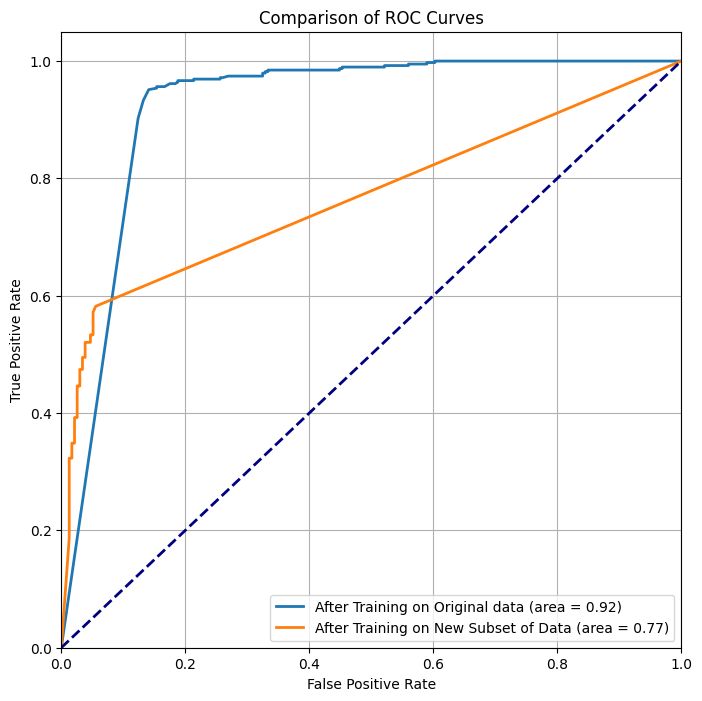

In [18]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

pl.seed_everything(42, workers=True)
    
# 1. Instantiate the LightningModule
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    training_mode='full_network',  # Change to 'classifier_only' if you want to train only the classifier
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE
)

# Optional: Print model summary
# You need to move the model to a device first for torchsummary to work
# summary(model.to('cuda'), (NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
# model.to('cpu') # Move it back if needed

# 2. Define Callbacks
# Save the best model based on validation accuracy
checkpoint_callback_full_model = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-full-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)


checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='checkpoints/',
    filename='simple-cnn-{epoch:02d}-{val_acc:.2f}',
    save_top_k=1,
    mode='max',
)

# A cleaner progress bar
progress_bar = TQDMProgressBar(refresh_rate=10)

# 3. Instantiate the Trainer for Multi-GPU Training
train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=2,                         # Number of GPUs to use
    strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn-full")
)

train_trainer_2 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=2,                         # Number of GPUs to use
    strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn")
)
# Create a separate Trainer for testing

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

test_trainer_2 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple_cnn_test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback],
    precision='16-mixed'  # Use mixed precision for testing
)


    # ===================================================================
# --- STEP 1: All TRAINING HAPPENS FIRST ---
# ===================================================================

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# Load the best model from Phase 1 to continue training
print(f"--- Loading best model from Phase 1 for further training ---")
#model = LitSimpleCNN.load_from_checkpoint(path_after_phase1) 

# Reinitialize the model with the same hyperparameters to forget the previous state
# This is optional, but ensures we start fresh for Phase 2
# If you want to continue training with the same model, you can skip this step
print(f"--- Reinitializing model for Phase 2 training ---")
model = LitSimpleCNN(
    in_channels=NUM_CHANNELS,
    num_classes=NUM_CLASSES,
    learning_rate=LEARNING_RATE,
    image_height=IMAGE_SIZE,
    image_width=IMAGE_SIZE,
)

# --- Phase 2 Training ---
print(f"\n\n--- Continuing Training for {NUM_EPOCHS} more epochs on new_train_loader ---")

train_trainer_2.fit(model, train_dataloaders=new_train_loader, val_dataloaders=val_loader)

# CRITICAL: Save the path to the final best model
path_after_phase2 = checkpoint_callback.best_model_path
print(f"Best model from Phase 2 saved to: {path_after_phase2}")


# ===================================================================
# --- STEP 2: All TESTING HAPPENS AT THE END ---
# ===================================================================
print("\n--- All training complete. Starting evaluation phase. ---")



# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_phase1["name"] = "After Training on Original data"

# --- Test 2: Evaluate the final model from after Phase 2 ---
print(f"\n--- Testing model from final checkpoint: {path_after_phase2} ---")
model.current_test_title = "ROC Curve after fine-tuning"
model = LitSimpleCNN.load_from_checkpoint(path_after_phase2)  # Load the model from Phase 2
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_2.test(model, dataloaders=test_loader, ckpt_path=path_after_phase2)
results_phase2 = model.last_test_results.copy()
results_phase2["name"] = "After Training on New Subset of Data"

# ===================================================================
# --- FINAL STEP: Plot the combined ROC curves ---
# ===================================================================
print("\n--- Generating Combined ROC Curve Plot ---")
plot_combined_roc_curves([results_phase1, results_phase2])

### Using SMOTE to augment the samples

In [19]:
# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=512, num_classes=1):
        super().__init__()
        self.output_layer = nn.Linear(input_features, num_classes)

    def forward(self, x):
        return self.output_layer(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, num_classes=1, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(input_features, num_classes)
        self.criterion = nn.BCEWithLogitsLoss()
        self.accuracy = torchmetrics.Accuracy(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)

        labels = labels.float().unsqueeze(1)
        loss = self.criterion(outputs, labels)
        self.log('classifier_train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [20]:
import pytorch_lightning as pl
from imblearn.over_sampling import SMOTE
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import torch
from torch.utils.data import TensorDataset, DataLoader
import math


# ===================================================================
# --- STAGE 1: Train on Original Images ---
# ===================================================================
print("--- STAGE 1: Training the full network ---")

model_s1 = LitSimpleCNN.load_from_checkpoint(checkpoint_callback.best_model_path)



model_s1.eval().to('cuda:0')
all_features = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(new_train_loader, desc="Feature Extraction"):
        inputs, labels = batch
        features = model_s1.model.extract_features(inputs.to('cuda:0'))
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

labels_flat = all_labels.flatten()





--- STAGE 1: Training the full network ---


Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 28.50it/s]


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



--- Visualizing features with t-SNE ---


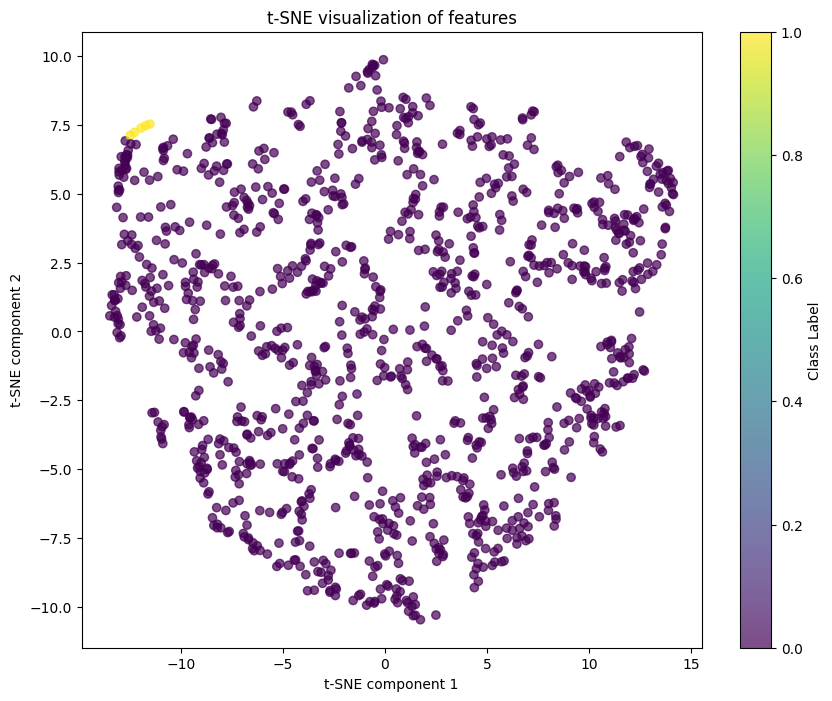

In [21]:
from sklearn.manifold import TSNE

print("\n--- Visualizing features with t-SNE ---")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust perplexity and n_iter as needed
features_2d_tsne = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 8))
scatter_tsne = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=labels_flat, cmap='viridis', alpha=0.7)
plt.title('t-SNE visualization of features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(scatter_tsne, label='Class Label')
plt.show()

Seed set to 42
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SimpleClassifier  | 513    | train
1 | criterion | BCEWithLogitsLoss | 0      | train
2 | accuracy  | BinaryAccuracy    | 0      | train
--------------------------------------------------------
513       Trainable params
0         Non-trainable params
513       Total params
0.002     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode



--- STAGE 2: Creating SMOTE'd 1D features ---
Feature set balanced. New dataset size: 2214

--- STAGE 3: Training new classifier on balanced features ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 35/35 [00:00<00:00, 162.09it/s, v_num=163]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 35/35 [00:00<00:00, 159.11it/s, v_num=163]

--- FINAL STEP: Evaluating both models ---


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Testing initial model from checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.50-v1.ckpt ---


Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.50-v1.ckpt
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:282: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val_acc', 'mode': 'max', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/simple-cnn-epoch=09-val_acc=0.50-v1.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 41.66it/s]
--- Final Test Metrics ---
Accuracy: 0.6106
AUC: 0.8808
Precision: 0.9682
Recall: 0.3897
F1-Score: 0.5558
Confusion Matrix:
tensor([[229,   5],
        [238, 152]], device='cuda:0')
--------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 36.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.6105769276618958
     test_auc_epoch          0.880774736404419
        test_loss           14.776296615600586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Testing final model (S1 Extractor + S3 Classifier) ---


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 20.83it/s]


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END .................................C=0.1, gamma=0.001; total time=   7.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=  11.9s
[CV] END ..................................C=0.1, gamma=0.01; total time=  13.0s
[CV] END ..................................C=0.1, gamma=0.01; total time=  13.0s
[CV] END .................................C=0.1, gamma=0.001; total time=   7.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=  14.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=  15.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=  15.3s
[CV] END .....................................C=0.1, gamma=1; total time=  15.4s
[CV] END .....................................C=0.1, gamma=1; total time=  15.7s
[CV] END .....................................C=0.1, gamma=1; total time=  16.0s
[CV] END .................................C=0.1,

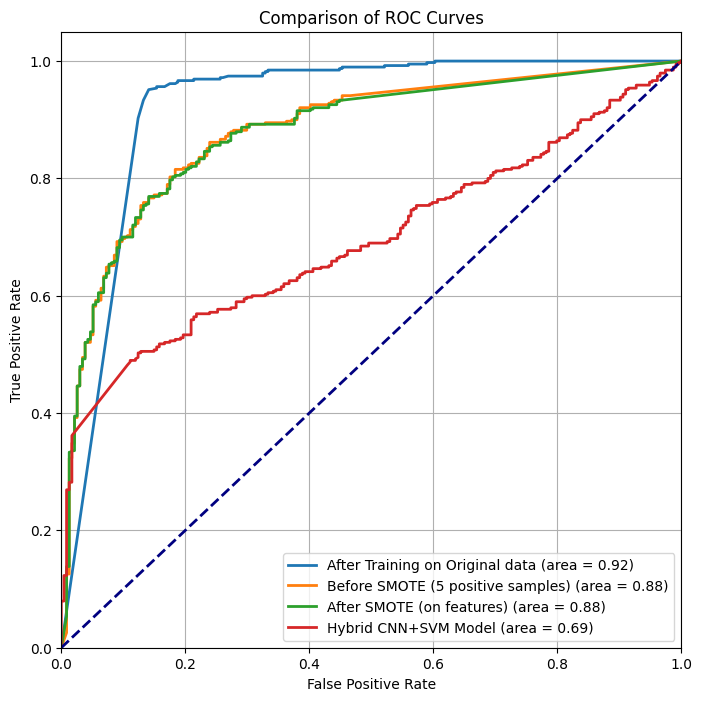

In [24]:
pl.seed_everything(42, workers=True)

# ===================================================================
# --- STAGE 2: Create SMOTE'd 1D features ---
# ===================================================================
print("\n--- STAGE 2: Creating SMOTE'd 1D features ---")
# Dynamically calculate k_neighbors
min_samples = min(np.bincount(labels_flat))
k_neighbors_value = max(1, min_samples - 1)

custom_sampling_strategy = {
    0: 1214,  # Assuming you have 234 majority samples
    1: 1000  # Your desired number for the minority class
}
smote = SMOTE(k_neighbors=k_neighbors_value, random_state=42, sampling_strategy=custom_sampling_strategy)

# Apply SMOTE to the 1D feature vectors

smote_features, smote_labels = smote.fit_resample(all_features, all_labels)
print(f"Feature set balanced. New dataset size: {smote_features.shape[0]}")
# ===================================================================
# --- STAGE 3: Train the New Classifier Head ---
# ===================================================================
print("\n--- STAGE 3: Training new classifier on balanced features ---")

# Create a new DataLoader for our balanced features
smote_dataset = TensorDataset(torch.from_numpy(smote_features).float(), torch.from_numpy(smote_labels).long())
smote_train_loader = DataLoader(smote_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Instantiate our new, simple classifier
classifier_model = LitClassifier(learning_rate=LEARNING_RATE)

trainer_classifier = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=10,
    deterministic=True
)

trainer_classifier.fit(classifier_model, train_dataloaders=smote_train_loader)

# ===================================================================
# --- FINAL STEP: Evaluating Both Models ---
# ===================================================================
print("\n--- FINAL STEP: Evaluating both models ---")

# Create a single trainer instance for all test runs
test_trainer = pl.Trainer(accelerator='gpu', devices=1)


path_s1_best = checkpoint_callback.best_model_path
# --- Test 1: Evaluate the original model from Stage 1 ---
print(f"\n--- Testing initial model from checkpoint: {path_s1_best} ---")
# We use the 'model_s1' object because its class has the on_test_epoch_end hook.
# The 'ckpt_path' argument ensures the correct weights are loaded into it.
test_trainer.test(model_s1, dataloaders=test_loader, ckpt_path=path_s1_best)

# Retrieve the results that were stored by the on_test_epoch_end hook
results_s1 = model_s1.last_test_results.copy()
results_s1["name"] = "Before SMOTE (5 positive samples)"


# --- Test 2: Evaluate the final combined model (Extractor + Classifier) ---
print(f"\n--- Testing final model (S1 Extractor + S3 Classifier) ---")

# To test the final model, we perform a two-step prediction
final_model_preds = []
final_model_labels = []
# Load the best feature extractor from Stage 1
feature_extractor_model = LitSimpleCNN.load_from_checkpoint(path_s1_best)
feature_extractor_model.eval().to('cuda:0')
classifier_model.eval().to('cuda:0')

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Final Model Evaluation"):
        inputs, labels = batch
        # Step 1: Get features from the Stage 1 model
        features = feature_extractor_model.model.extract_features(inputs.to('cuda:0'))
        # Step 2: Get final predictions from the Stage 3 classifier
        predictions = classifier_model(features)
        
        final_model_preds.append(predictions.cpu())
        final_model_labels.append(labels.cpu())

# Now calculate ROC for the final combined model
all_final_preds = torch.cat(final_model_preds)
all_final_labels = torch.cat(final_model_labels)

final_auc = torchmetrics.functional.auroc(all_final_preds, all_final_labels.int(), task="binary")
fpr, tpr, _ = torchmetrics.functional.roc(
    torch.sigmoid(all_final_preds), all_final_labels.int(), task="binary"
)
test_f1_val = torchmetrics.functional.f1_score(all_final_preds, all_final_labels.int(), task="binary")
test_prec = torchmetrics.functional.precision(all_final_preds, all_final_labels.int(), task="binary")
test_rec = torchmetrics.functional.recall(all_final_preds, all_final_labels.int(), task="binary")
test_cm_val = torchmetrics.functional.confusion_matrix(all_final_preds, all_final_labels.int(), task="binary")

results_s2 = {"fpr": fpr, "tpr": tpr, "auc": final_auc, "f1": test_f1_val, "precision": test_prec, "recall": test_rec, "cm": test_cm_val, "name": "After SMOTE (on features)"}


# Use SVM classifier as classification head

#Extract test features
model_s1.eval().to('cuda:0')
test_features = []
test_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Feature Extraction"):
        inputs, labels = batch
        features = model_s1.model.extract_features(inputs.to('cuda:0'))
        test_features.append(features.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
        
test_features = np.concatenate(test_features, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

test_labels_flat = test_labels.flatten()

#Train SVM classifier on the SMOTE'd features
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define a parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# Create a grid search object
# cv=3 means 3-fold cross-validation
grid_search_svm = GridSearchCV(
    SVC(kernel='rbf', probability=True, random_state=42),
    param_grid,
    verbose=2, # Shows progress
    cv=3,
    n_jobs=10
)

# Fit the grid search on your balanced features
# This will automatically find the best hyperparameters
grid_search_svm.fit(smote_features, smote_labels)

print(f"Best SVM parameters found: {grid_search_svm.best_params_}")

# Use the best estimator found by the grid search for your final evaluation
svm_classifier = grid_search_svm.best_estimator_
svm_classifier.fit(smote_features, smote_labels)
# Predict on the test features
svm_scores = svm_classifier.predict_proba(test_features)[:, 1]
# Convert to PyTorch tensors for torchmetrics
svm_scores_tensor = torch.from_numpy(svm_scores)
test_labels_tensor = torch.from_numpy(test_labels).int().squeeze()

print("\n\n" + "="*50)
print("--- FINAL PERFORMANCE COMPARISON ---")
print("="*50)
print(f"\n--- Model Before SMOTE ---")
print(f"AUC: {results_s1['auc']:.4f}")
print(f"Precision: {results_s1['precision']:.4f}")
print(f"Recall: {results_s1['recall']:.4f}")
print(f"F1-Score: {results_s1['f1']:.4f}")
print(f"Confusion Matrix:\n {results_s1['cm']}")

print(f"\n--- Model After SMOTE ---")
print(f"AUC: {results_s2['auc']:.4f}")
print(f"Precision: {results_s2['precision']:.4f}")
print(f"Recall: {results_s2['recall']:.4f}")
print(f"F1-Score: {results_s2['f1']:.4f}")
print(f"Confusion Matrix:\n {results_s2['cm']}")
print("\n" + "="*50)



# Calculate metrics using torchmetrics
final_auc = torchmetrics.functional.auroc(svm_scores_tensor, test_labels_tensor, task="binary")
fpr, tpr, _ = torchmetrics.functional.roc(svm_scores_tensor, test_labels_tensor, task="binary")
final_f1 = torchmetrics.functional.f1_score(svm_scores_tensor, test_labels_tensor, task="binary")
final_cm = torchmetrics.functional.confusion_matrix(svm_scores_tensor, test_labels_tensor, task="binary")
final_precision = torchmetrics.functional.precision(svm_scores_tensor, test_labels_tensor, task="binary")
final_recall = torchmetrics.functional.recall(svm_scores_tensor, test_labels_tensor, task="binary")

# Store results for plotting
results_hybrid = {
    "fpr": fpr, "tpr": tpr, "auc": final_auc, "f1": final_f1, "cm": final_cm,
    "precision": final_precision, "recall": final_recall,
    "name": "Hybrid CNN+SVM Model"
}

# You can now compare this to your original model's results (results_s1)
print("\n--- Hybrid CNN+SVM Model Results after SMOTE---")
print(f"AUC: {results_hybrid['auc']:.4f}")
print(f"Precision: {results_hybrid['precision']:.4f}")
print(f"Recall: {results_hybrid['recall']:.4f}")
print(f"F1-Score: {results_hybrid['f1']:.4f}")
print(f"Confusion Matrix:\n {results_hybrid['cm']}")

# --- Plot the combined ROC curves ---
print("\n--- Generating Combined ROC Curve Plot ---")
plot_combined_roc_curves([results_phase1, results_s1, results_s2, results_hybrid])




--- Visualizing features with t-SNE ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


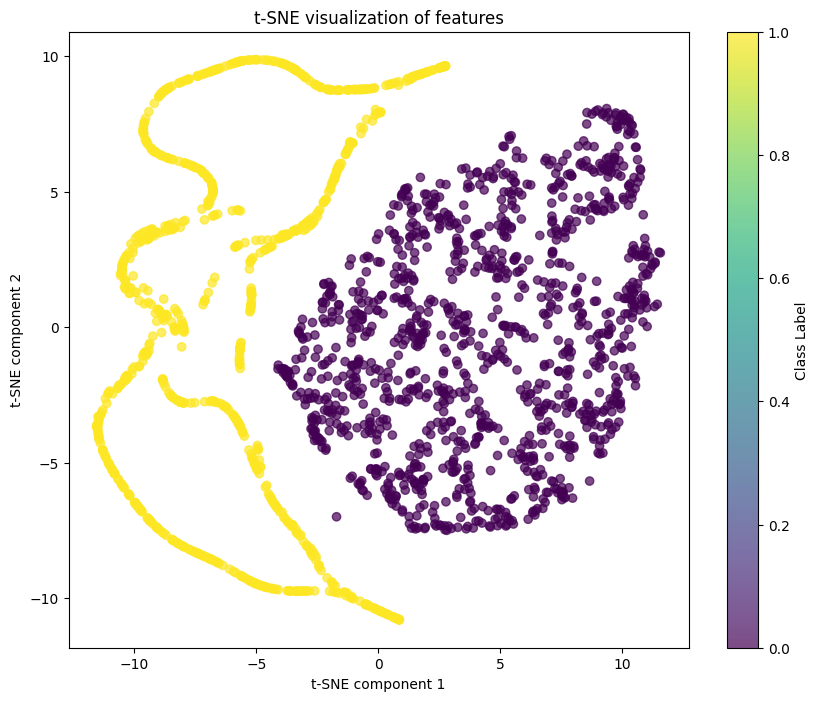

In [26]:
smote_labels_flat = smote_labels.flatten()
print("\n--- Visualizing features with t-SNE ---")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust perplexity and n_iter as needed
features_2d_tsne = tsne.fit_transform(smote_features)

plt.figure(figsize=(10, 8))
scatter_tsne = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=smote_labels_flat, cmap='viridis', alpha=0.7)
plt.title('t-SNE visualization of features')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar(scatter_tsne, label='Class Label')
plt.show()